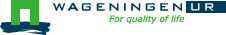



# 1. Calibrating assimilate partitioning with logistic functions

This notebook demonstrates the calibration of partitioning by replacing them with logistic functions. The input data used are observations from field experiments for potato obtained for culvivar 'Fontane' at an experimental site near Lelystad in 2020


**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts
  4. The `nlopt` module for non-linear optimization
  5. the `dotmap` module
  
Allard de Wit, June 2023

## 1.1 Importing the relevant modules

First the required modules need to be imported.

In [1]:
%matplotlib inline
import sys, os
from pathlib import Path
from dotmap import DotMap
import pcse
import pandas as pd
import numpy as np
import nlopt
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
from pcse.fileinput import YAMLAgroManagementReader, YAMLCropDataProvider
from pcse.util import DummySoilDataProvider, WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.engine import Engine
from pcse.models import Wofost71_PP
from libfunc import logistic_sigmoid
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.12 | packaged by conda-forge | (default, Sep 16 2021, 01:40:49) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.5


## 1.2 Experiment details and data directory

The experiments use the folowing cultivar codes:
- C1 Innovator
- C2 Fontane
- C3 Markies
- C4 Premiere
- C5 Fontane
- C6 Festien


In [2]:
from pathlib import Path
location = "Le"
variety = "C2"
year = 2020
this_dir = Path.cwd()
data_dir = this_dir / "data"

## 1.3 a plotting function
The function below is used to plot data easily

In [3]:
def make_plots(df, df_obs, df_compare=None):
    """A function for plotting data
    
    :param df: a dataframe with WOFOST simulation results
    :param df_obs: a dataframe with potato experimental data
    :param df: a dataframe with WOFOST simulation results to compare with
    """
    plots = [DotMap(title="Total crop biomass", variable="TAGP", observation="TotalDM", units="kg/ha"),
             DotMap(title="Leaf biomass", variable="WLV", observation="LeafDM", units="kg/ha"),
             DotMap(title="Stem biomass", variable="TWST", observation="StemDM", units="kg/ha"),
             DotMap(title="Tuber biomass", variable="TWSO", observation="TuberDM", units="kg/ha"),
             DotMap(title="Leaf area index", variable="LAI", observation="LAI", units="-")
            ]
    fig, axes = plt.subplots(figsize=(16,14), nrows=3, ncols=2, sharex=True)
    for plot, ax in zip(plots, axes.flatten()):
        df[plot.variable].plot(ax=ax)
        df_obs[plot.observation].plot(ax=ax, marker="o", linestyle="")
        if df_compare is not None:
            df_compare[plot.variable].plot(ax=ax, linestyle=":")
        ax.set_title("%s [%s]" % (plot.title, plot.units))
        ax.set_ylabel(plot.units)
    fig.autofmt_xdate()

# 2. Setup the model
## 2.1 Weather data

In [5]:
from pcse.fileinput import ExcelWeatherDataProvider
weather_fname = data_dir / "meteo" / f"weatherfile_{location}_{year}.xlsx"
wdp = ExcelWeatherDataProvider(weather_fname)

## 2.2 Parameters

In [6]:
cropd = YAMLCropDataProvider(fpath=data_dir / "crop", force_reload=True)
soild = DummySoilDataProvider()
sited = WOFOST71SiteDataProvider(WAV=10)
params = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

## 2.3 Agromanagement

In [8]:
agro = YAMLAgroManagementReader(data_dir / "agro" / f"AGMT_{variety}_{year}.agro")
print(agro)

!!python/object/new:pcse.fileinput.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2020-04-20:
    CropCalendar:
      crop_end_date: 2020-11-03
      crop_end_type: maturity
      crop_name: potato
      crop_start_date: 2020-04-20
      crop_start_type: sowing
      max_duration: 300
      variety_name: Potato_C2_C5
    StateEvents: null
    TimedEvents: null



## 2.4 Results for default parameters

In [9]:
conf = str(this_dir / "conf" / "Wofost72_PP_notebook_11.conf")
wofsim = Engine(params, wdp, agro, config=conf)
wofsim.run_till_terminate()
df_default = pd.DataFrame(wofsim.get_output())
df_default.index = pd.to_datetime(df_default.day)

# 3. Observed data

## 3.1 Read observations from excel

In [10]:
df_obs = pd.read_excel(data_dir / "obs" / f"OBSV_{variety}_{year}.xlsx")
df_obs.index = pd.to_datetime(df_obs.DateMeas)
df_obs.tail(25)

,Dynamics,DateMeas,SLA,LeafDM,StemDM,TuberDM,TotalDM,TuberFM,LAI,Phenology,DVS,Date
DateMeas,,,,,,,,,,,,
2020-06-08,C2,2020-06-08,185.353250,422.503624,96.182448,0.000000,518.686073,0.000000,0.783577,NaN,NaN,NaN
2020-06-21,C2,2020-06-21,216.741036,1469.952103,466.980393,1139.640672,3076.573168,8602.220308,3.210881,NaN,NaN,NaN
2020-07-13,C2,2020-07-13,265.960000,1836.000000,993.000000,6107.334389,8936.334389,46212.571405,4.428320,NaN,NaN,NaN
2020-08-03,C2,2020-08-03,268.240972,1649.952103,1017.609318,9657.705361,12325.266781,46212.571405,4.428320,NaN,NaN,NaN
2020-09-07,C2,2020-09-07,206.099428,981.522075,875.226102,NaN,NaN,NaN,1.982688,NaN,NaN,NaN
2020-09-14,C2,2020-09-14,182.608070,741.377371,945.098515,16358.424432,18044.900318,70345.443150,1.350288,NaN,NaN,NaN
2020-09-18,C2,2020-09-18,NaN,NaN,NaN,18234.186508,NaN,79342.222223,NaN,NaN,NaN,NaN


## 3.2 Plot simulation results and observations

The plots below demonstrate the results with the default parameters for potato. These model parameters were originally derived for cultivar "bintje" and it is evident that tuber yields are strongly underestimated for a modern cultivar like "fontane". 

Analysis demonstrated that the partitioning tables derived for Bintje were not working well for Fontane and therefore had to be calibrated. Additionally, the maximum assimilation rate (AMAX) was found to be higher than the default values used so far. Since AMAX was measured directly, we did not calibrate AMAX but instead updated the values directly (see under 4.2).

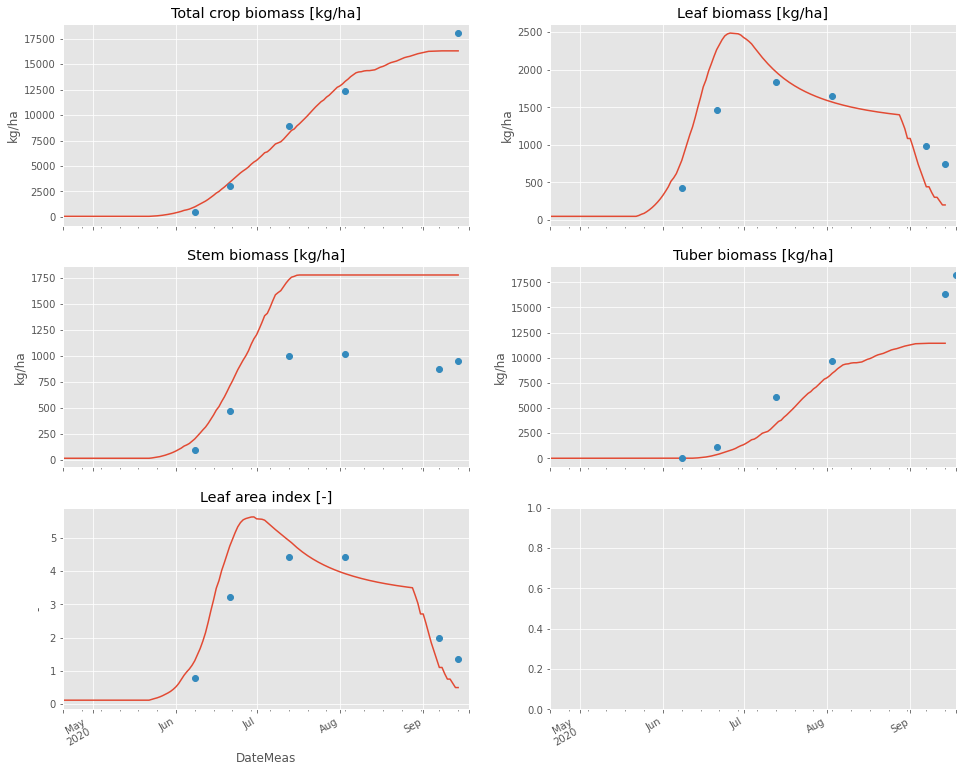

In [11]:
make_plots(df_default, df_obs)

# 4. Calibration of parameters

## 4.1 classes for partitioning
The classes below generate the partitioning tables from logistic function. See doc strings for the function parameters. The classes `FOTB` and `FLTB` generate the partitioning function for storage organs and leaves, while the partitioning to stems is computed as the remainder so:

$FSTB = 1.0 - FOTB - FLTB$

Use the function `compute_partition_function()` to generate a consistent set of tables for FOTB, FLTB and FSTB including checks to avoid negative partitioning values.

In [36]:
class FOTB:
    """Implements partitioning to storage organs

    FOTBa defines the steepness of the function (default 20)
    FOTBb defines the location of the centre point (default 1.0)
    FOTBc defines the fraction allocated to organs at DVS=2 (default 1.0)
    """
    def __init__(self, FOTBa=20, FOTBb=1.2, FOTBc=1.0):
        self.FOTBa=FOTBa
        self.FOTBb=FOTBb
        self.FOTBc=FOTBc
        
    def __call__(self, x):
        FO = logistic_sigmoid(x, a=self.FOTBc,  b=self.FOTBa, c=self.FOTBb)
        if FO >= 0.99:
            return 1.0
        elif FO <= 0.01:
            return 0.0
        else:
            return FO


class FLTB:
    """Implements partitioning to leaves

    FLTBa defines the steepness of the function (default 5)
    FLTBb defines the location of the centre point (default 1.0)
    FLTBc defines the initial amount of partitioning to leaves at DVS=0 (default 0.85)
    FLTBd defines the final amount of partitioning to leaves at DVS=2 (default 0)
    
    Note that allowing a fraction of partitioning to leaves at DVS=2 (e.g. setting FLTBd=A) 
    also requires setting FOTBc=(1-A). Otherwise FOTB will override the partitioning to
    leaves.
    """
    def __init__(self, FLTBa=5, FLTBb=1.0, FLTBc=0.85, FLTBd=0.0):
        self.FLTBa = FLTBa
        self.FLTBb = FLTBb
        self.FLTBc = FLTBc
        self.FLTBd = FLTBd
        
    def __call__(self, x):
        FL = logistic_sigmoid(x, a=(self.FLTBc-self.FLTBd), 
                              b=-self.FLTBa, c=self.FLTBb, d=self.FLTBd)
        if FL > 0.99:
            return 1.0
        elif FL < 0.01:
            return 0.0
        else:
            return FL

def compute_partition_functions(FOTBpar={}, FLTBpar={}, warn=True, stepsize=0.01):
    """Computes the set of partition tables FOTB, FLTB and FSTB based
    on the individual simmoid function parameters for FOTB and FLTB. 
    
    FSTB is computed as the remainder: 1.0 - FOTB - FSTB
    
    Checks for negative partitioning are being applied. Note that the 
    order of precedence is FOTB, FLTB, FSTB
    """ 
    fltb = FLTB(**FLTBpar)
    fotb = FOTB(**FOTBpar)
    sigm_DVS = np.arange(0,2.1, stepsize)
    sigm_FOTB = np.array([fotb(d) for d in sigm_DVS])
    sigm_FLTB = np.array([fltb(d) for d in sigm_DVS])
    if any((sigm_FLTB + sigm_FOTB) > 1.0):
        sigm_FLTB = np.minimum(sigm_FLTB, 1.0 - sigm_FOTB)
        if warn:
            print("Warning: adjusting for negative partioning values")

    sigm_FSTB = 1. - sigm_FOTB - sigm_FLTB 
    # Convert to X, Y pairs as array
    sigm_FLTB2 = np.array(list(zip(sigm_DVS, sigm_FLTB))).flatten()
    sigm_FSTB2 = np.array(list(zip(sigm_DVS, sigm_FSTB))).flatten()
    sigm_FOTB2 = np.array(list(zip(sigm_DVS, sigm_FOTB))).flatten()
    
    return sigm_FOTB2, sigm_FLTB2, sigm_FSTB2

## 4.2 A model rerunner
The class reruns the model with the given parameter values in array `par_values`, over-riding the default ones. Note that besides the partitioning functions, we are also including the relative growth rate for LAI (RGRLAI) and the life span of leaves (SPAN) parameters in the calibration. 

The `AMAXTB` parameter is not calibrated but forced to a new value based on field measurements.

In [15]:
class ModelRerunner():
    """Reruns a given model with different values of the given parameters.
    
    Returns a pandas DataFrame with time-series simulation results of the model.
    
    WARNING: this class requires adaptation for different sets of parameters because
    the partitioning requires specific handling.
    """
    parameters = ["RGRLAI", "SPAN", "FLTBa", "FLTBb", "FLTBc", "FOTBa", "FOTBb"]
    
    def __init__(self, params, wdp, agro):
        self.params = params
        self.wdp = wdp
        self.agro = agro
        
    def __call__(self, par_values):
        # Check if correct number of parameter values were provided
        if len(par_values) != len(self.parameters):
            msg = "Optimizing %i parameters, but %i values were provided!" % (len(self.parameters), len(par_values))
            raise RuntimeError(msg)
        
        # Clear any existing overrides
        self.params.clear_override()
        
        # Compute partitioning tables from logistic function parameters
        FLTBpar = dict(zip(self.parameters[2:5], par_values[2:5]))
        FOTBpar = dict(zip(self.parameters[5:7], par_values[5:7]))
        FOTB, FLTB, FSTB = compute_partition_functions(FOTBpar=FOTBpar, FLTBpar=FLTBpar, warn=False)
        
        # map par_values to function parameters
        mapping = {"RGRLAI": par_values[0], 
                   "SPAN":par_values[1], 
                   "FLTB": FLTB, "FOTB": FOTB, "FSTB": FSTB,
                   "AMAXTB": [0.00, 35.00, 2.00, 35.00]
                  }
        
        # Set overrides for the new parameter values
        for parname, value in mapping.items():
            self.params.set_override(parname, value)
            
        # Run the model with given parameter values
        conf = str(Path.cwd() / "conf" / "Wofost72_PP_notebook_11.conf")
        wofost = Engine(params, wdp, agro, config=conf)
        wofost.run_till_terminate()
        df = pd.DataFrame(wofost.get_output())
        df.index = pd.to_datetime(df.day)
        return df

### 4.2.1 Test the rerunner
You can easily test if the rerunner works by modifying the `test_values` and looking at the results.

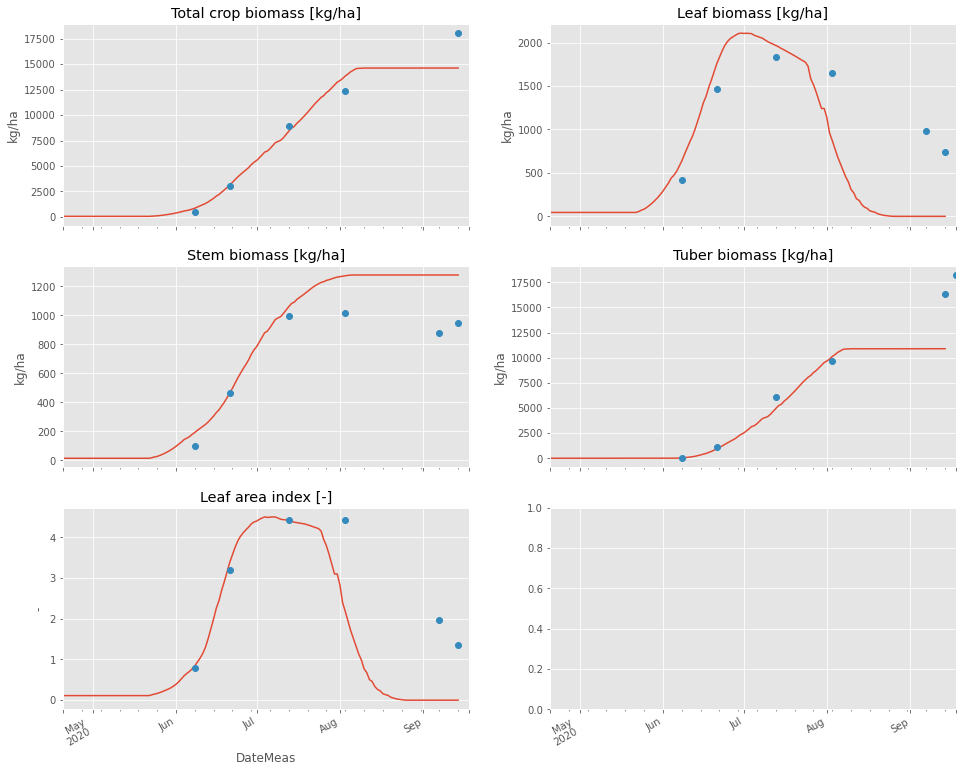

In [16]:
m = ModelRerunner(params, wdp, agro)
test_values = [0.010, 20, 15, 1.1, 0.75, 10, 1.1]
df = m(test_values)
make_plots(df, df_obs)

## 4.3 The objective function calculator
The object function calculator computes the difference between the simulated values and the observed values from the experiment. The differences are returned as a single RMSE value. 

Note that because we have different observations with different magnitudes (tuberweight varies up till 15000, while LAI varies up till 6) all the differences are normalized on the mean of the observations. Further, the different variables have a weight factor assigned that can be used  to put more or less emphasis on a particular variable. By default all weights are 1.0

In [17]:
class ObjectiveFunctionCalculator():
    """Computes the objective function.
    
    This class runs the simulation model with given parameter values and returns the objective
    function as the sum of squared difference between observed and simulated variables weighted by
    the value in variable_weights.
    
    All variables are first normalized on the mean of the observations.
    """
    variable_mapping = {"LeafDM": "WLV", "TuberDM": "TWSO", "StemDM":"WST", "LAI":"LAI"}
    variable_weights = {"LeafDM": 1.0, "TuberDM": 1.0, "StemDM": 1.0, "LAI":1.0}
    
    def __init__(self, params, wdp, agro, observations):
        self.modelrerunner = ModelRerunner(params, wdp, agro)
        self.df_observations = observations
        self.n_calls = 0
       
    def __call__(self, par_values, grad=None):
        """Runs the model and computes the objective function for given par_values.
        
        The input parameter 'grad' must be defined in the function call, but is only
        required for optimization methods where analytical gradients can be computed.
        """
        self.n_calls += 1
        print(".", end="")
        # Run the model and collect output
        self.df_simulations = self.modelrerunner(par_values)
        # compute the differences by subtracting the DataFrames
        # Note that the dataframes automatically join on the index (dates)
        weighted_RMSE = 0.
        for obs_column_name, wofost_col_name in self.variable_mapping.items():
            mean_value = self.df_observations[obs_column_name].mean()
            differences = self.df_simulations[wofost_col_name] - self.df_observations[obs_column_name]
            RMSE = np.sqrt(np.mean((differences/mean_value)**2))
            weighted_RMSE += RMSE * self.variable_weights[obs_column_name]
            
        return weighted_RMSE

### 4.3.1 Test the objective function calculator
You can test the objective function calculator by feeding in some test values and looking at the RMSE returned.

In [18]:
ofc = ObjectiveFunctionCalculator(params, wdp, agro, df_obs)
# parvalues have to be in this order: ["RGRLAI", "SPAN", "FLTBa", "FLTBb", "FLTBc", "FOTBa", "FOTBb"]
test_values = [0.015, 20, 15, 1.1, 0.85, 10, 1.1]
rmse = ofc(test_values)
print(f"\nRMSE: {rmse}")

.
RMSE: 1.9966980944972774


## 4.4 Running the optimization
The `NLOPT` optimizer is used for the actual optimization process. It requires several steps, see the comments below. I have good experiences with two optimzation algorithms: `nlopt.nlopt.GN_DIRECT_L` which is a global search algorithm and `nlopt.nlopt.LN_SUBPLEX` which is a local, gradient-based optimizer (simplex type).

NOTE: Although default (start) values are defined below, this has no impact for the results of the DIRECT_L optimizer which runs independently of the initial values. For other optimizers changing the start values can have a large impact. Therefore, the optimizer uses a two stage approach: First a global search with DIRECT_L, next refining the results with SUBPLEX.


In [19]:
def run_optimizer(optimizer, start_values, tolerance, max_eval=500):
    lower_boundary = [0.010, 25,  5, 0.8, 0.70,  5, 0.9]
    upper_boundary = [0.015, 40, 25, 1.3, 0.95, 25, 1.3]
    init_step_size = [0.001,  2,  2, 0.05, 0.01, 2, 0.05]

    # Set the random seed to have predictable sequences
    nlopt.srand(19730703)
    # Start optimizer with designated optimizer and 7 parameters
    opt = nlopt.opt(optimizer, len(start_values))
    # Start the object function calculator
    objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_obs)
    #opt = nlopt.opt(nlopt.nlopt.LN_SBPLX, len(default_values))
    # Assign the objective function calculator
    opt.set_min_objective(objfunc_calculator)
    # lower bounds of parameters values
    opt.set_lower_bounds(lower_boundary)
    # upper bounds of parameters values
    opt.set_upper_bounds(upper_boundary)
    # the initial step size to compute numerical gradients
    opt.set_initial_step(init_step_size)
    # Maximum number of evaluations allowed
    opt.set_maxeval(max_eval)
    # Relative tolerance for convergence
    opt.set_ftol_rel(tolerance)
    # Start optimizer
    x = opt.optimize(start_values)

    print("\nminimum value = ",  opt.last_optimum_value())
    print("result code = ", opt.last_optimize_result())
    print("With %i function calls" % objfunc_calculator.n_calls)
    print("Retrieved values:")
    for parname, value in zip(ModelRerunner.parameters, x):
        print(f"{parname}: {value}")
    return x

# Default values must be provided but they have no impact when using DIRECT_L
default_values = [0.013, 36, 7, 1.25, 0.93, 6, 1.22]

print("FIRST STAGE OPTIMIZATION:")
x0 = run_optimizer(nlopt.GN_DIRECT_L, default_values, tolerance=0.1)    

print("SECOND STAGE OPTIMIZATION:")
x1 = run_optimizer(nlopt.LN_SBPLX, x0, tolerance=0.01)    


FIRST STAGE OPTIMIZATION:
...................................................
minimum value =  0.6864110709657509
result code =  3
With 51 function calls
Retrieved values:
RGRLAI: 0.010833333333333334
SPAN: 37.5
FLTBa: 8.333333333333334
FLTBb: 1.05
FLTBc: 0.7416666666666666
FOTBa: 8.333333333333334
FOTBb: 1.1
SECOND STAGE OPTIMIZATION:
.....................................................................................................................................
minimum value =  0.5509595645102747
result code =  3
With 133 function calls
Retrieved values:
RGRLAI: 0.010475786361575732
SPAN: 36.59512229584952
FLTBa: 8.46961148240488
FLTBb: 1.0605648487325192
FLTBc: 0.7358931622866465
FOTBa: 7.7706364597476
FOTBb: 1.081089065567871


## 4.5 Plotting new results vs the default results

The newly calibrated results are given as the orange line. Results with the old parameters are shown in the dotted lines. It is evident that the calibration had a large improvement in the estimation of the different variables. 

The total crop biomass seems now overestimated by WOFOST, but this is actually not the the case. The output from WOFOST covers the total crop biomass including dead leaf and stem material. In contrast, the field experimental data do not cover the dead leaf and stem biomass which is generally lost and difficult to measure in the field.

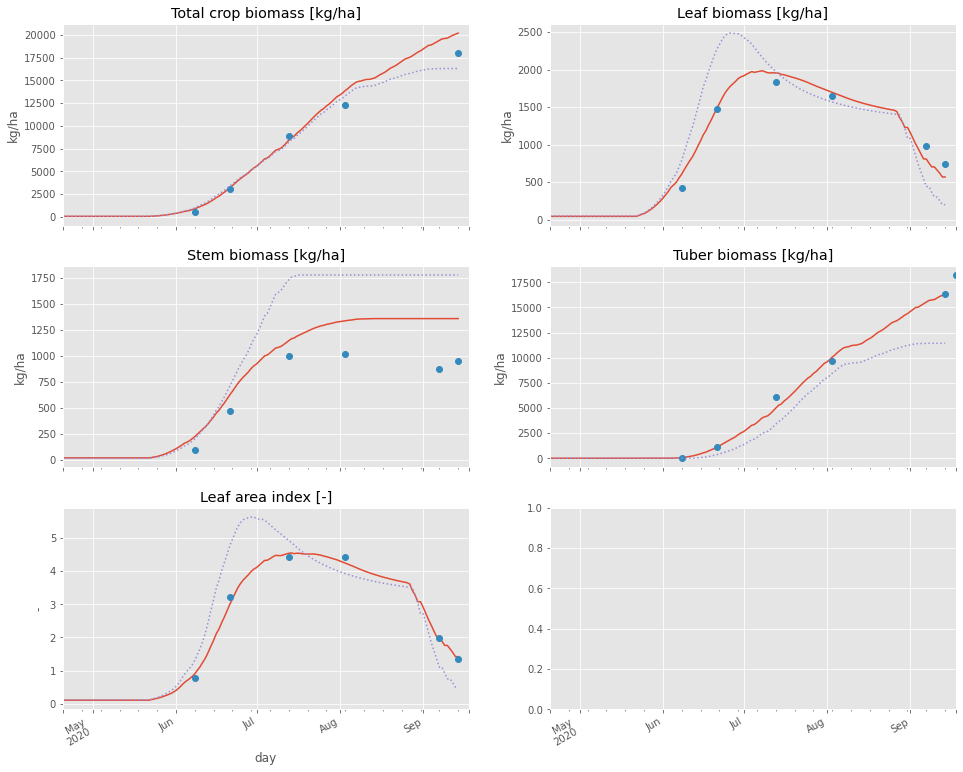

In [19]:
df_calibrated = m(x1)
make_plots(df_calibrated, df_obs, df_default)

## 4.6 Final partitioning tables
We can now compute the final partitioning tables from the vector with calibration results `x1` by feeding them into the `compute_partition_functions()`. 

For the final tables, we decrease the stepsize in DVS to 0.1, otherwise the tables become very long.

In [38]:
FLTBpar = dict(zip(ModelRerunner.parameters[2:5], x1[2:5]))
FOTBpar = dict(zip(ModelRerunner.parameters[5:7], x1[5:7]))
FOTBfinal, FLTBfinal, FSTBfinal = compute_partition_functions(FOTBpar=FOTBpar, FLTBpar=FLTBpar, 
                                                              warn=True, stepsize=0.1)
df = pd.DataFrame({"DVS": FOTBfinal[0::2],
                   "FOTB": FOTBfinal[1::2],
                   "FLTB": FLTBfinal[1::2],
                   "FSTB": FSTBfinal[1::2],})
df = df.set_index("DVS")
df.head(5)

,FOTB,FLTB,FSTB
DVS,,,
0.0,0.0,0.735801,0.264199
0.1,0.0,0.735678,0.264322
0.2,0.0,0.735391,0.264609
0.3,0.0,0.734722,0.265278
0.4,0.0,0.733168,0.266832


And below the final tables plotted in a chart

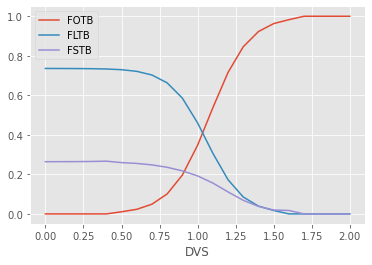

In [40]:
fig = df.plot()